In [316]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp
from jax.image import scale_and_translate

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import apply_psf, simulate_projection, PI, get_wavelen, xpci_2matdecomp
from chromatix.ops import init_plane_resample

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False)
    ax.add_artist(scalebar)

# CRLB tests

In [229]:
## params

energies = jnp.array([24.0, 34.0])  

fov = .5e-3 
phantom_Nx = 256
   
mat1, p1 = 'Al(100.0)', 2.699
mat2, p2 = 'H(11.2)O(88.8)', 1.0
mat1_dn, mat1_beta = get_delta_beta_mix(mat1, energies, p1)
mat2_dn, mat2_beta = get_delta_beta_mix(mat2, energies, p2)

t1 = 0.3e-3  
t2 = 1.1e-3
w = 120e-6

R = 200e-3
I0 = 1.0
det_shape = (100, 100)           
det_px = fov / det_shape[0]   
phantom_shape = (phantom_Nx, phantom_Nx)
phantom_px = fov / phantom_Nx
det_fwhm = 2*det_px 

matinfo1 = [mat1, p1, t1]
matinfo2 = [mat2, p2, t2]
mus = 2 * (2 * PI / get_wavelen(energies)) * jnp.array([mat1_beta, mat2_beta])
ds = jnp.array([mat1_dn, mat2_dn])



In [317]:
## crlb calc
E_i = energies[0]
R_i = 10e-3

    
kx = np.fft.fftfreq(phantom_Nx, d=phantom_px)
KX, KY = np.meshgrid(kx, kx)
sinc2D = np.sinc(w*KX) * np.sinc(w*KY) / (phantom_px/w)**2  # normalize rect amplitude = 1
K2 = 4 * PI**2 * (KX**2 + KY**2)  # angular freq's for Aij


def detect_img(x, in_px=phantom_px, out_shape=det_shape, out_px=det_px, det_fwhm=det_px, normalize=False):
    """
    create the detector resampling function
    this should be applied to both signals m and partials dm/dt before the Fisher info calc.
    """
    scale = jnp.array([in_px/out_px, in_px/out_px])
    translation = -0.5 * (scale*jnp.array(x.shape) - jnp.array(out_shape))
    total = x.sum()
    x = scale_and_translate(x, out_shape, (0,1), scale, translation, method='linear')
    if normalize:
        x = x * (total / x.sum())
    if det_fwhm is not None:
        x = apply_psf(x, x.shape[0]*out_px, out_px, fwhm=det_fwhm, psf='lorentzian', kernel_width=0.1)
    return x
    

def get_Aij(E_i, R_i, mat_j, p_j):
    delta_ij, beta_ij = get_delta_beta_mix(mat_j, E_i, p_j)
    mu_ij = 2 * (2 * PI / get_wavelen(E_i)) * beta_ij
    return (R_i * K2 * delta_ij) + mu_ij
Aij_test = get_Aij(E_i, R_i, mat1, p1)


def get_mi(E_i, R_i, matinfo1, matinfo2):
    mat1, p1, t1 = matinfo1
    mat2, p2, t2 = matinfo2
    Ai1 = get_Aij(E_i, R_i, mat1, p1)
    Ai2 = get_Aij(E_i, R_i, mat2, p2)    
    iFT = np.fft.fftshift(np.fft.ifft2(sinc2D * (Ai1*t1 + Ai2*t2))).real
    return detect_img(np.exp(-iFT)) 
mi_test = get_mi(E_i, R_i, matinfo1, matinfo2)
# plt.imshow(mi_test, cmap='bwr', vmin=0.8, vmax=1.2)
# plt.title(f'min: {mi_test.min()} \n max {mi_test.max()}')
# plt.colorbar()
# plt.show()


def get_dmi_dAij(mi, Aij):
    iFT = np.fft.fftshift(np.fft.ifft2(sinc2D * Aij)).real
    return mi * detect_img(iFT)
# dmi_dAij_test = get_dmi_dAij(mi_test, Aij_test)
# plt.imshow(dmi_dAij_test)
# plt.colorbar()
# plt.show()

### get CRLB!
    # TODO



# Simulation tests

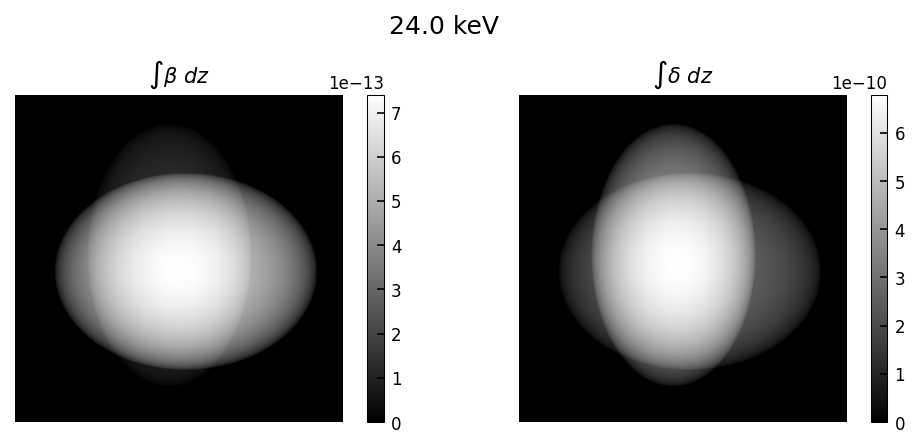

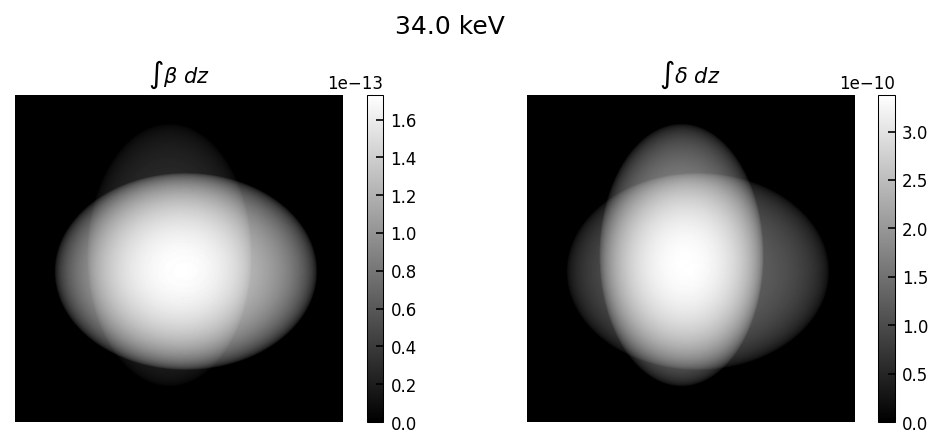

In [2]:
# make projections

energies = jnp.array([24.0, 34.0])  

fov = 1e-3 
phantom_Nx = 512
   
mat1, p1 = 'Al(100.0)', 2.699
mat2, p2 = 'H(11.2)O(88.8)', 1.0
mat1_dn, mat1_beta = get_delta_beta_mix(mat1, energies, p1)
mat2_dn, mat2_beta = get_delta_beta_mix(mat2, energies, p2)

t1 = 0.3e-3   #0.1 * fov 
t2 = 1.1e-3   #0.9 * fov   

phantom_shape = [phantom_Nx, phantom_Nx]  # assume isotropic
phantom_px = fov / phantom_shape[0]

### WEAK EDGE PHANTOM
tmap1 = jnp.sum(jnp.load('vol1_512.npy'), axis=0)
tmap2 = jnp.sum(jnp.load('vol2_512.npy'), axis=0)
tmap1 *= t1 / jnp.max(tmap1)
tmap2 *= t2 / jnp.max(tmap2)

### STRONG EDGE PHANTOM
# tmap1, tmap2 = jnp.zeros([2, phantom_shape[0], phantom_shape[1]])
# x = jnp.arange(-fov/2, fov/2, phantom_px) + phantom_px/2
# X, Y = jnp.meshgrid(x, x)
# tmap1 = tmap1.at[(3*X/fov)**2 + (4*Y/fov)**2 <= 1].set(t1)
# tmap2 = tmap2.at[(4*X/fov)**2 + (3*Y/fov)**2 <= 1].set(t2)

for e, E in enumerate(energies):
    
    beta_proj = mat1_beta[e]*tmap1 + mat2_beta[e]*tmap2
    dn_proj = mat1_dn[e]*tmap1 + mat2_dn[e]*tmap2
    
    fig, ax = plt.subplots(1, 2, figsize=[7,3])
    fig.suptitle(f'{E} keV')
    for i, stuff in enumerate(zip([beta_proj, dn_proj],['$\int \\beta ~dz$', '$\int \\delta ~dz$'])):
        im, ttl = stuff
        m = ax[i].imshow(im)
        fig.colorbar(m, ax=ax[i])
        ax[i].axis('off')
        ax[i].set_title(ttl)
    fig.tight_layout()
    plt.show()

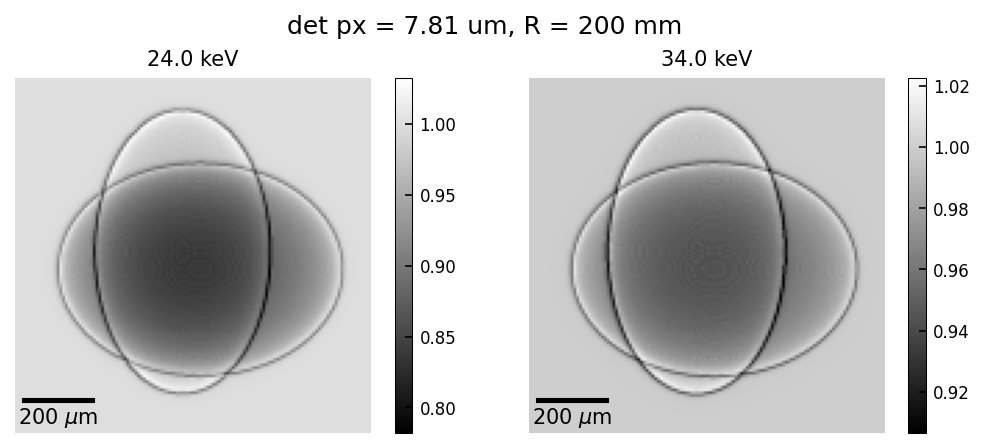

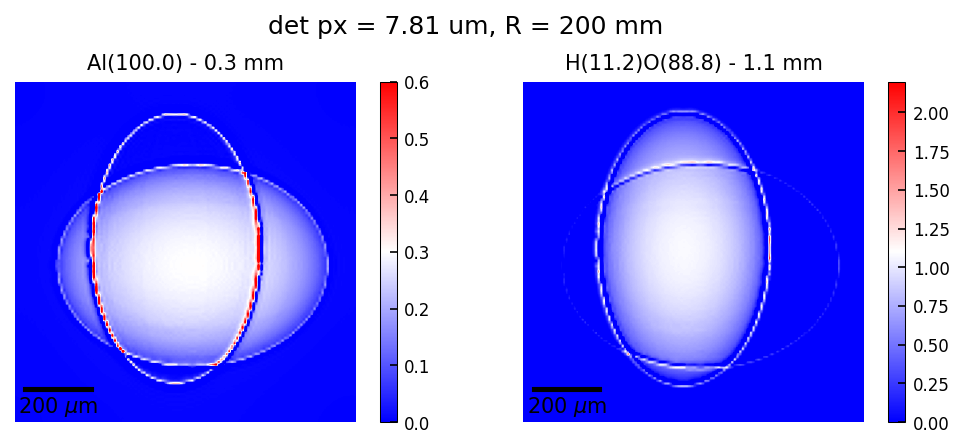

CPU times: user 873 ms, sys: 40.7 ms, total: 914 ms
Wall time: 836 ms


In [4]:
%%time

R = 200e-3
I0 = None
det_shape = (128, 128)           
det_px = fov / det_shape[0]    # as pixel size reduces/ det shape increases, the success of matdecomp reduces!
det_fwhm = det_px 

imgs = []
for e, E in enumerate(energies):
    beta_proj = mat1_beta[e]*tmap1 + mat2_beta[e]*tmap2
    dn_proj = mat1_dn[e]*tmap1 + mat2_dn[e]*tmap2
    img = simulate_projection(beta_proj, dn_proj, phantom_px, det_shape, det_px, det_fwhm, E, R, I0)
    imgs.append(img)
imgs = jnp.array(imgs)

fig, ax = plt.subplots(1, 2, figsize=[7,3])
kw = {'vmin':0.75, 'vmax':1.1}   #{'vmin':jnp.min(imgs), 'vmax':jnp.max(imgs)}
for i, im in enumerate(imgs):
    m = ax[i].imshow(im)#, **kw)
    fig.colorbar(m, ax=ax[i])
    ax[i].axis('off')
    ax[i].set_title(f'{energies[i]} keV')
    add_scalebar(ax[i], 0.2, im.shape[0], det_px*1e6, '$\\mu$m')
fig.suptitle(f'det px = {det_px*1e6:.2f} um, R = {R*1e3:.0f} mm')
fig.tight_layout()
plt.show()


mus = 2 * (2 * PI / get_wavelen(energies)) * jnp.array([mat1_beta, mat2_beta])
ds = jnp.array([mat1_dn, mat2_dn])
img_mat1, img_mat2 = xpci_2matdecomp(imgs, det_px, R, mus, ds)


fig, ax = plt.subplots(1, 2, figsize=[7,3])
for i, im in enumerate([img_mat1, img_mat2]):
    m = ax[i].imshow(im*1e3, vmin=0, vmax=[t1, t2][i]*2e3, cmap='bwr')
    fig.colorbar(m, ax=ax[i])
    ax[i].axis('off')
    ax[i].set_title(f'{[mat1, mat2][i]} - {[t1, t2][i]*1e3:.1f} mm')
    add_scalebar(ax[i], 0.2, im.shape[0], det_px*1e6, '$\\mu$m')
fig.suptitle(f'det px = {det_px*1e6:.2f} um, R = {R*1e3:.0f} mm')
fig.tight_layout()
plt.show()